In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime
from matplotlib.ticker import FormatStrFormatter

In [2]:
colors = {
    "DQN": 'darkorange',
    "REINFORCE": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
starting_exp = 4000
ending_exp = 4071
save_processed_data = True
#exp_lists_preformatted = ['4000_4035.csv'] #, '4072_4107.csv'] # Existing formatted datasets
exp_lists_preformatted = []

target_agg_count = 10
target_reward_type = 'greedy'

exp_agent_data = []

experiments = range(starting_exp, ending_exp + 1)

# REMOVE THIS
#algos = ['DQN', 'PPO', 'CMA']
train_types = ['eval', 'train']

if len(exp_lists_preformatted) == 0:
    for train_type in ['train', 'eval']:
        for ind, exp_num in enumerate(experiments):
            config_fname = f'./Exp_{exp_num}/config.yaml'
            
            c = load_config_file(config_fname)
            nn_c = c['nn_hyperparameters']
            federated_c = c['federated_learning_settings']
            algo_c = c['algorithm_settings']
            env_c = c['environment_settings']
            eval_c = c['eval_config']
            cma_c = c['cma_parameters']
    
            if federated_c['aggregation_count'] != target_agg_count:
                print(f"Experiment {exp_num} does not have matching aggregation level")
                continue

            rtype = 'communal' if nn_c['average_rewards_when_training'] else 'greedy'

            if rtype != target_reward_type:
                print(f"Experiment {exp_num} does not have matching reward type")
                continue
            
            ev_info = []
        
            seed = env_c['seed']
        
            algorithm_dm = algo_c['algorithm']
            
            def load_from_json_with_error_handling(filepath, columns_specific):
                try:
                    return read_csv_data(filepath, columns=columns_specific)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
                    return None  # Handle the error and return None or an empty object
            
            
            d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
            
            if not os.path.exists(d_base):
                d_base = f"../metrics/Exp_{exp_num}"
                    
            base_path = f"{d_base}/{train_type}/metrics"
        
            print(f'Loading {base_path}_agent_metrics.csv')
            agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv', ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward',])
            
            agent_data['seed'] = seed
            agent_data['exp_num'] = exp_num
            
            agent_data['algorithm'] = algorithm_dm
            #agent_data['algorithm'] = algos[ind % len(algos)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
        
            agent_data['train_type'] = train_type
            #agent_data['train_type'] = train_types[(ind // len(algos)) % len(train_types)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
            
            agent_data['season'] = env_c['season']    
            agent_data['num_aggs'] = federated_c['aggregation_count']    
            agent_data['eps_per_agg'] = cma_c['max_generations'] if algorithm_dm == 'CMA' else nn_c['num_episodes']
        
            exp_agent_data.append(agent_data)

Experiment 4000 does not have matching aggregation level
Experiment 4001 does not have matching aggregation level
Experiment 4002 does not have matching aggregation level
Loading ../../../../storage_1/metrics/Exp_4003/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4004/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4005/train/metrics_agent_metrics.csv
Experiment 4006 does not have matching aggregation level
Experiment 4007 does not have matching aggregation level
Experiment 4008 does not have matching aggregation level
Experiment 4009 does not have matching aggregation level
Experiment 4010 does not have matching aggregation level
Experiment 4011 does not have matching aggregation level
Loading ../../../../storage_1/metrics/Exp_4012/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4013/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4014/train/metrics_agent_metrics.csv
Experiment 40

In [4]:
if len(exp_lists_preformatted) == 0:
    # Convert data to DataFrame for easier manipulation
    df_agent = pd.concat(exp_agent_data, ignore_index=True)
    
    cumulative_agent_df = (
        df_agent
        .groupby(
            ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'algorithm', 'season', 'train_type', 'eps_per_agg']
        )['reward']
        .sum()
        .reset_index()
    )
    
    # Rename the 'reward' column to 'cumulative_reward' for clarity
    cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)
    
    # Get recalculated episodes using (aggregation number * episodes per aggregation) + episode number
    cumulative_agent_df['episode'] = cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']
    
    cumulative_agent_df.head()

In [5]:
# Define the file path with starting_exp and ending_exp variables
file_path_for_processed_data = f'../../../../storage_1/metrics/formatted_experiment_data/part_5/'

if len(exp_lists_preformatted) == 0:

    cumulative_avg_reward_by_algorithm = (
        cumulative_agent_df
        .groupby(['episode', 'algorithm', 'seed', 'train_type'])['cumulative_reward']
        .mean()
        .reset_index()
    )
    
    cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
        ['algorithm', 'seed', 'train_type', 'episode']
    )
    
    cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
        cumulative_avg_reward_by_algorithm
        .groupby(['algorithm', 'seed', 'train_type'])['cumulative_reward']
        .transform(lambda x: x.expanding().mean())
    )
    
    if save_processed_data:
        if not os.path.exists(file_path_for_processed_data):
            os.makedirs(file_path_for_processed_data)
        
        # Save the DataFrame to a CSV file
        cumulative_avg_reward_by_algorithm.to_csv(f"{file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv", index=False)
        
        print(f"Data successfully saved to {file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv")

if len(exp_lists_preformatted) > 0:
    dataframes = []
    
    # Load and combine datasets
    for existing_set in exp_lists_preformatted:
        loaded_dataset = pd.read_csv(f"{file_path_for_processed_data}/{existing_set}")
        # Combine datasets
        dataframes.append(loaded_dataset)

    cumulative_avg_reward_by_algorithm = pd.concat(dataframes, ignore_index=True)

Data successfully saved to ../../../../storage_1/metrics/formatted_experiment_data/part_5//4000_4071.csv


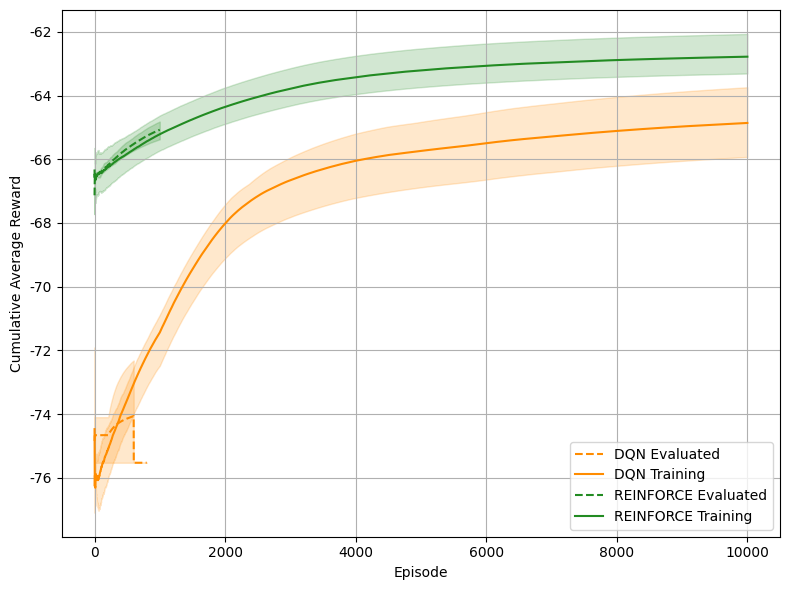

In [6]:
# Define linestyles for 'train' and 'eval'
linestyles = {'train': '-', 'eval': '--'}

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted figsize for better visibility

algorithms = cumulative_avg_reward_by_algorithm['algorithm'].unique()
train_types = cumulative_avg_reward_by_algorithm['train_type'].unique()

for algo in algorithms:
    for train_type in train_types:
        # Filter the data for the current algorithm and train_type
        data = cumulative_avg_reward_by_algorithm[
            (cumulative_avg_reward_by_algorithm['algorithm'] == algo) &
            (cumulative_avg_reward_by_algorithm['train_type'] == train_type)
        ].copy()  # Use copy to avoid modifying the original DataFrame

        if data.empty:
            continue  # Skip if no data for this combination

        # For 'eval' train_type, adjust cumulative_reward to prevent decreasing within each exp_num
        if train_type == 'eval':
            data = data.sort_values(['seed', 'episode'])
            data['cumulative_reward'] = data.groupby('seed')['cumulative_reward'].cummax()

        # Compute min, max, mean cumulative_reward per episode across all exp_num
        min_cumulative_avg_reward = data.groupby('episode')['cumulative_reward'].min()
        max_cumulative_avg_reward = data.groupby('episode')['cumulative_reward'].max()
        mean_cumulative_avg_reward = data.groupby('episode')['cumulative_reward'].mean()

        # Plot the range as a filled area
        ax.fill_between(
            min_cumulative_avg_reward.index,
            min_cumulative_avg_reward.values,
            max_cumulative_avg_reward.values,
            alpha=0.2,
            color=colors[algo]
        )
        algo_name = algo
        if algo_name == 'CMA':
            algo_name = 'CMA-ES'
        # Plot the mean cumulative reward
        ax.plot(
            mean_cumulative_avg_reward.index,
            mean_cumulative_avg_reward.values,
            label=f'{algo_name} {"Training" if train_type == "train" else "Evaluated"}',
            color=colors[algo],
            linestyle=linestyles[train_type]
        )

ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Average Reward')
ax.legend(loc='lower right')
ax.grid(True)

# Set y-axis to display integers only
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

fig.tight_layout()
plt.savefig('./Figures/evaluation_vs_training.png', dpi=300, bbox_inches='tight')
plt.show()